# Age Estimation using CNN Age Classes

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import shutil

import copy

from pathlib import Path
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

import gc

## Age estimation in age groups

### Set image size and variables 

In [3]:
IMAGE_SIZE = [56,56] 
BASE_DIR = './UTKFace/'
OUTPUT_DIR = './UTKFaceSmote/'
NR_EPOCHS = 80
BATCH_SIZE = 30
NUM_CLASSES = 116 

In [4]:
# check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Split Dataset into validation and test set 
### SMOTE 

In [5]:
class UTKFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [file for file in os.listdir(root_dir) if file.endswith('.jpg') or file.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)
        
        age = int(self.images[idx].split('_')[0])
        
        if self.transform:
            image = self.transform(image)
        
        return image, age

# convert images
transform = transforms.Compose([
    transforms.Resize((56, 56)),
    transforms.ToTensor(),
])

full_dataset = UTKFaceDataset(root_dir=BASE_DIR, transform=transform)

# split dataset 
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# fixed seed for same split across models
generator = torch.Generator().manual_seed(116)

smote_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=generator
)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# extract images and labels for SMOTE
images = []
labels = []
for img, label in smote_dataset:
    images.append(img.numpy())
    labels.append(label)

images = np.array(images)
labels = np.array(labels)

class_counts = Counter(labels)
print("Original class distribution:", class_counts)


valid_classes = [classes for classes, count in class_counts.items() if count > 5]
invalid_classes = [classes for classes, count in class_counts.items() if count <= 5]
print("\nValid classes (> 5 samples):", valid_classes)
print("\nInvalid classes (<= 5 samples):", invalid_classes)
invalid_indices = np.isin(labels, invalid_classes)
valid_indices = np.isin(labels, valid_classes)
val_images = images[valid_indices]
val_labels = labels[valid_indices]
inv_images  = images[invalid_indices]
inv_labels = labels[invalid_indices]

n_samples = val_images.shape[0]
images_flattened = val_images.reshape(n_samples, -1)

smote = SMOTE(random_state=42)
images_resampled, labels_resampled = smote.fit_resample(images_flattened, val_labels)

smote_images = images_resampled.reshape(-1, *val_images.shape[1:])  

# save smote samples
for i, (img, label) in enumerate(zip(smote_images, labels_resampled)):
    img = (img * 255).astype(np.uint8)  
    img = Image.fromarray(img.transpose(1, 2, 0))
    img.save(os.path.join(OUTPUT_DIR, f'{label}_age_{i}_smote.jpg'))

for i, (img, label) in enumerate(zip(inv_images, inv_labels)):
    img = (img * 255).astype(np.uint8)  
    img = Image.fromarray(img.transpose(1, 2, 0))  
    img.save(os.path.join(OUTPUT_DIR, f'{label}_age_{i}_original.jpg'))

print(f"All images saved to {OUTPUT_DIR}")

# load SMOTE dataset
smote_dataset = UTKFaceDataset(root_dir=OUTPUT_DIR, transform=transform)

saved_labels = []
for _, label in smote_dataset:
    saved_labels.append(label)

final_class_distribution = Counter(saved_labels)
print("\nFinal class distribution after saving and loading:")
print(final_class_distribution)

# create DataLoaders
train_loader = DataLoader(smote_dataset, batch_size=BATCH_SIZE, shuffle=True)

Original class distribution: Counter({26: 1519, 1: 800, 28: 644, 35: 626, 24: 586, 25: 511, 30: 506, 32: 460, 27: 426, 29: 398, 40: 366, 36: 335, 2: 324, 45: 307, 23: 298, 34: 284, 22: 269, 50: 266, 54: 247, 31: 246, 21: 244, 38: 228, 3: 220, 60: 216, 4: 207, 37: 203, 20: 198, 39: 192, 8: 189, 42: 188, 58: 187, 18: 184, 16: 182, 55: 178, 65: 176, 53: 167, 56: 163, 52: 150, 5: 141, 9: 124, 75: 123, 49: 117, 15: 117, 43: 116, 47: 114, 14: 112, 17: 111, 61: 110, 48: 109, 85: 105, 33: 103, 70: 102, 7: 102, 46: 102, 10: 102, 51: 98, 6: 93, 80: 93, 62: 91, 12: 89, 41: 86, 72: 73, 67: 69, 68: 69, 63: 68, 44: 68, 19: 65, 57: 61, 59: 61, 90: 59, 13: 58, 66: 54, 78: 52, 76: 45, 73: 41, 11: 40, 69: 39, 64: 29, 74: 27, 88: 26, 86: 26, 82: 26, 89: 23, 71: 22, 77: 20, 84: 18, 79: 16, 83: 12, 81: 11, 96: 10, 87: 8, 92: 8, 100: 7, 110: 5, 95: 5, 93: 4, 116: 4, 105: 4, 99: 4, 91: 2, 101: 2, 115: 2, 111: 1, 103: 1})

Valid classes (> 5 samples): [22, 27, 53, 85, 2, 26, 32, 66, 73, 37, 45, 28, 3, 21, 65,

### Create Model

In [6]:
class CNNNet(nn.Module):
    def __init__(self, NUM_CLASSES=116):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(96),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(384),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Sequential(
            nn.Linear(384, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, NUM_CLASSES)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
# instantiate model
model = CNNNet(NUM_CLASSES).to(device)

# model summary
print(model)

from torchsummary import summary
summary(model.to(device),(3,56,56))
# sample input
sample_input = torch.randn(1, 3, 56, 56).to(device)
output = model(sample_input)
print(f"Output shape: {output.shape}")

CNNNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Sequential(
    (0): Linear(in_features=384, out_features=512, bias=True)
    (1): ReLU()
    (2)

In [8]:
writer = SummaryWriter('./Project/class_imbalance/runs/smote_image', comment='Smote_Class_Model_Image')

In [9]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

# age_classes tensor
age_classes = torch.tensor([i for i in range(1, NUM_CLASSES + 1)]).to(device)

### Train model

In [10]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, summary_writer, device, save_path):
    
    # create history for graphs
    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': [],
        'mae': [],
        'val_mae': []
    }
    # create cuda events for timetracking
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    
    # init variables for saving
    best_val_mae = float('Inf') 
    best_model_wts = copy.deepcopy(model.state_dict()) 
    
    start.record()
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        num_train = 0
        num_train_correct = 0
        total_train_mae = 0.0
        total_val_mae = 0.0
        
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            # shift labels from 1-116 to 0-115 for loss
            targets_model = targets - 1
            inputs, targets_model = inputs.to(device), targets_model.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            
            loss = loss_fn(outputs, targets_model)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            _, predicted = outputs.max(1)
            predicted = predicted + 1
            num_train += targets.size(0)
            num_train_correct += predicted.eq(targets).sum().item()

            probabilities = F.softmax(outputs, dim=1)
            expected_age = torch.sum(probabilities * age_classes, dim=1) + 1
            total_train_mae += torch.abs(expected_age - targets.float()).sum().item()
                  
        training_loss /= len(train_loader)
        train_accuracy = num_train_correct / num_train
        train_mae = total_train_mae / num_train

        if epoch+1 == NR_EPOCHS:
            end.record()
            torch.cuda.synchronize()
        
        model.eval()
        num_val = 0
        num_val_correct = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch
                # shift labels from 1-116 to 0-115 for loss
                targets_model = targets - 1
                inputs, targets_model = inputs.to(device), targets_model.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                
                loss = loss_fn(outputs, targets_model)
                valid_loss += loss.item()
                _, predicted = outputs.max(1)
                predicted = predicted + 1
                num_val += targets.size(0)
                num_val_correct += predicted.eq(targets).sum().item() 

                probabilities = F.softmax(outputs, dim=1)
                expected_age = torch.sum(probabilities * age_classes, dim=1) + 1
                total_val_mae += torch.abs(expected_age - targets.float()).sum().item()
        
        valid_loss /= len(val_loader)
        val_accuracy = num_val_correct / num_val
        val_mae = total_val_mae / num_val

        summary_writer.add_scalar('Train Loss', training_loss, epoch+1)
        summary_writer.add_scalar('Val Loss', valid_loss, epoch+1)
        summary_writer.add_scalar('Accuracy', train_accuracy, epoch+1)
        summary_writer.add_scalar('Validation Accuracy', val_accuracy, epoch+1)
        summary_writer.add_scalar('Train MAE', train_mae, epoch+1)
        summary_writer.add_scalar('Val MAE', val_mae, epoch+1)
    
        history['loss'].append(training_loss)
        history['val_loss'].append(valid_loss)
        history['accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)
        history['mae'].append(train_mae)
        history['val_mae'].append(val_mae)

        print(f'Epoch [{epoch+1}/{NR_EPOCHS}], Training Loss: {training_loss:.2f}, Validation Loss: {valid_loss:.2f}, '
              f'Training Accuracy: {train_accuracy:.2f}, Validation Accuracy: {val_accuracy:.2f}, Training MAE: {train_mae:.2f}, Validation MAE: {val_mae:.2f}')
        
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)
            print(f"Best model saved at epoch {epoch+1} with validation MAE: {best_val_mae:.2f}")

    print(f'Training time:  {round(start.elapsed_time(end), 1) / 60000} minutes')    
    return history

In [11]:
history = train(model, optimizer, loss_fn, train_loader, val_loader, NR_EPOCHS, writer, device, './Project/class_imbalance/smote/smote_model_image_test_split')
writer.close()

Epoch [1/80], Training Loss: 4.70, Validation Loss: 4.51, Training Accuracy: 0.02, Validation Accuracy: 0.07, Training MAE: 24.40, Validation MAE: 23.54
Best model saved at epoch 1 with validation MAE: 23.54
Epoch [2/80], Training Loss: 4.54, Validation Loss: 4.28, Training Accuracy: 0.03, Validation Accuracy: 0.08, Training MAE: 22.73, Validation MAE: 17.97
Best model saved at epoch 2 with validation MAE: 17.97
Epoch [3/80], Training Loss: 4.37, Validation Loss: 4.22, Training Accuracy: 0.04, Validation Accuracy: 0.08, Training MAE: 21.04, Validation MAE: 17.80
Best model saved at epoch 3 with validation MAE: 17.80
Epoch [4/80], Training Loss: 4.18, Validation Loss: 4.01, Training Accuracy: 0.05, Validation Accuracy: 0.07, Training MAE: 17.35, Validation MAE: 12.11
Best model saved at epoch 4 with validation MAE: 12.11
Epoch [5/80], Training Loss: 3.94, Validation Loss: 4.89, Training Accuracy: 0.06, Validation Accuracy: 0.04, Training MAE: 13.39, Validation MAE: 28.06
Epoch [6/80], T

## Training Histories

In [12]:
def plot_history(history, path_name):
    # loss
    loss_train = history['loss']
    loss_val = history['val_loss']
    epochs = range(NR_EPOCHS)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(path_name + '_loss.png', bbox_inches='tight')
    plt.show()
    

    # mae
    accuracy_train = history['mae']
    accuracy_val = history['val_mae']
    epochs = range(NR_EPOCHS)
    plt.plot(epochs, accuracy_train, 'g', label='Training MAE')
    plt.plot(epochs, accuracy_val, 'b', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(path_name + '_mae.png', bbox_inches='tight')
    plt.show()
    

### History of normal model

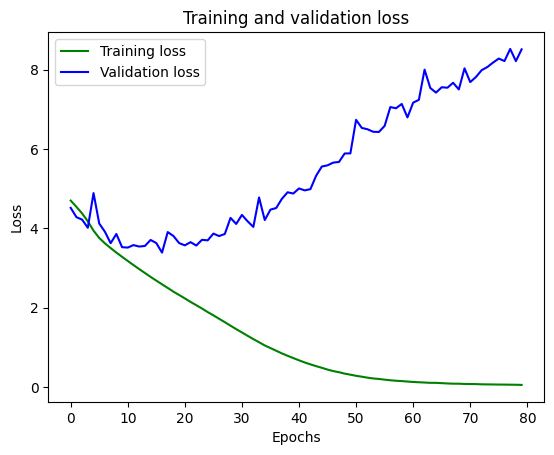

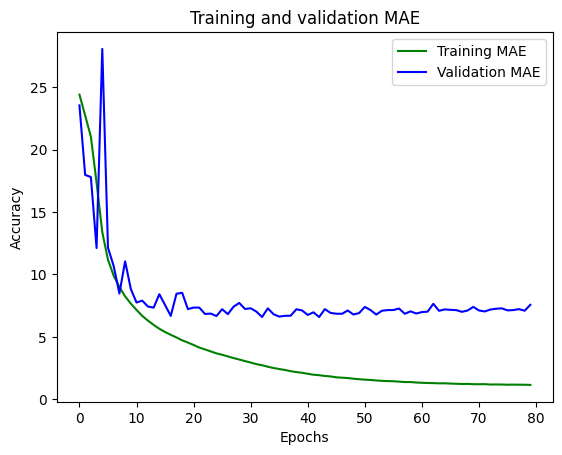

In [13]:
plot_history(history, './Project/class_imbalance/smote/smote_images_test_split')

## Test models

In [14]:
def test(model, test_loader, loss_fn ,name):
    test_loss = 0
    test_correct = 0
    test_total = 0
    total_test_mae = 0
    
    # create cuda events for timetracking
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()
    with torch.no_grad():
        for inputs, labels in test_loader:
            # shift labels from 1-116 to 0-115 for loss
            labels_model = labels - 1
            inputs, labels_model = inputs.to(device), labels_model.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels_model)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            predicted = predicted + 1
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

            probabilities = F.softmax(outputs, dim=1)
            expected_age = torch.sum(probabilities * age_classes, dim=1) + 1
            total_test_mae += torch.abs(expected_age - labels.float()).sum().item()   

    end.record()
    torch.cuda.synchronize()
    test_loss = test_loss / len(test_loader)
    test_accuracy = test_correct / test_total
    test_mae = total_test_mae / test_total

    print(f'Model: {name},  Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}, Test MAE: {test_mae:.2f}')
    print(f'Time:  {round(start.elapsed_time(end), 1) / 1000} seconds')

In [15]:
### Benchmarks

In [16]:
# load models
model_normal = CNNNet(NUM_CLASSES)
model_normal.load_state_dict(torch.load('./Project/class_imbalance/smote/smote_model_image_test_split'))

test(model_normal.to(device), test_loader, loss_fn, 'SMOTE images model')

Model: SMOTE images model,  Test Loss: 4.72, Test Accuracy: 0.09, Test MAE: 10.21
Time:  2.8798000000000004 seconds
